In [ ]:
!pip install transformers
from transformers import BertModel, BertTokenizer
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

     |████████████████████████████████| 2.1MB 6.7MB/s 
     |████████████████████████████████| 3.3MB 34.9MB/s 
     |████████████████████████████████| 901kB 39.6MB/s 


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/rec/dataset/sentiment_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/rec/dataset/sentiment_test.csv")

In [ ]:
validation_df = df.sample(1000)
train_df = df.drop(validation_df.index)

In [ ]:
train_df.to_csv("/content/drive/MyDrive/rec/dataset/train_df.csv")
validation_df.to_csv("/content/drive/MyDrive/rec/dataset/validation.csv")
test_df.to_csv("/content/drive/MyDrive/rec/dataset/test_df.csv")

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/rec/dataset/train_df.csv")
validation_df = pd.read_csv("/content/drive/MyDrive/rec/dataset/validation.csv")
test_df = pd.read_csv("/content/drive/MyDrive/rec/dataset/test_df.csv")

In [ ]:
len(train_df), len(validation_df), len(test_df)

(26486, 1000, 3535)

In [ ]:
train_df = train_df.fillna(".")
validation_df = validation_df.fillna(".")
test_df = test_df.fillna(".")

In [ ]:
def preprocess(text):
  text = str(text)
  punctuation = '"#$%&!?\()*+-/:;<=>[\\]^_`{|}~'
  text = text.lower()
  all_text = ''.join([c for c in text if c not in punctuation])
  s_text = all_text.split()
  s = []
  for c in s_text:
    if ((c.startswith('@') != True) and (c.startswith('http') != True)):
      s.append(c)
  s = ' '.join(s)
  return s

for i in range(5):
    print(preprocess(df['text'][i]))

spent the entire morning in a meeting w a vendor, and my boss was not happy w them. lots of fun. i had other plans for my morning
oh good idea about putting them on ice cream
says good or should i say bad afternoon
i dont think you can vote anymore i tried
haha better drunken tweeting you mean


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def get_input(df, batch_size, max_input_tokens, gpu):
  batch = np.random.choice(df.index.size, size=(batch_size, ), replace=False)
  tweet_array = []
  for i in batch:
    tweet_array.append(preprocess(df['text'][i]))
  tweet_tensors = tokenizer(tweet_array, truncation=True, padding=True, max_length=max_input_tokens, return_tensors='pt')
  attention_mask = tweet_tensors['attention_mask']
  tweet_tensor = tweet_tensors['input_ids']
  if gpu:
    tweet_tensor = tweet_tensor.cuda()
    attention_mask = attention_mask.cuda()
  label = get_label(df, batch, gpu)

  return tweet_tensor, attention_mask, label

def get_label(df, batch, gpu):

  label_tensors = []
  for i in batch:
      label_tensors.append(get_label_num(df['sentiment'][i]))
  label_tensors = torch.LongTensor(label_tensors)
  if gpu:
    label_tensors = label_tensors.cuda()

  return label_tensors

def get_label_num(s):
    if s == "neutral":
        num = 0
    elif s == "positive":
        num = 1
    elif s == "negative":
        num = 2
    return num

In [ ]:
class Bert_Sentiment(nn.Module):
    def __init__(self):
        super(Bert_Sentiment, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.layer_out = nn.Linear(768, 3)

    def forward(self, input, attention_mask=None):
        bert_out = self.bert(input, attention_mask=attention_mask)[1]
        bert_out = self.dropout(bert_out)
        out = self.layer_out(bert_out)
        return out

model = Bert_Sentiment()
model = model.cuda()

In [ ]:
out = model(tweet_tensor, attention_mask)
criterion = nn.CrossEntropyLoss()
criterion(out, label), label.size(), out.argmax(dim=-1).size()

(tensor(0.8907, device='cuda:0', grad_fn=<NllLossBackward>),
 torch.Size([5]),
 torch.Size([5]))

In [ ]:
def train_i(batch_size, max_length, train_dataset, optimizer, model, gpu):
    criterion = nn.CrossEntropyLoss()
    batch = np.random.choice(train_dataset.index.size, (batch_size, ))
    model.train()
    optimizer.zero_grad()
    tweet_tensor, attention_mask, label = get_input(train_dataset, batch_size, max_length, gpu)
    output = model(tweet_tensor, attention_mask)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    return loss.item()
    del loss, output

def validation_i(batch_size, max_length, train_dataset, model, gpu):
    with torch.no_grad():
        criterion = nn.CrossEntropyLoss()
        batch = np.random.choice(train_dataset.index.size, (batch_size, ))
        model.eval()
        tweet_tensor, attention_mask, label = get_input(train_dataset, batch_size, max_length, gpu)
        output = model(tweet_tensor, attention_mask)
        loss = criterion(output, label)
    return loss.item()
    del loss, output

def validation_loop(validation_dataset, max_length, batch_size, model, gpu):
    with torch.no_grad():
        batch = np.random.choice(validation_dataset.index.size, (batch_size, ), replace=False)
        model.eval()
        tweet_tensor, attention_mask, label = get_input(validation_dataset, batch_size, max_length, gpu)
        acc_t = []
        for i in range(batch_size):
            output = model(tweet_tensor[i].unsqueeze(0), attention_mask[i].unsqueeze(0))
            acc = label[i].unsqueeze(0) == output.argmax(-1)
            acc_t.append(acc.unsqueeze(0))
            del output, acc
        acc_t = torch.cat(acc_t, dim=0)
        acc_per = acc_t.sum()/batch_size
        return acc_per


def train(model, epochs, show_count, batch_size, max_length, train_dataset, validation_dataset, gpu, model_path):
    if gpu:
        model = model.cuda()
    else:
        model = model.cpu()
    train_history = []
    validation_history = []
    acc = []
    start_time = time.time()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    for epoch in range(epochs):
        loss_train = train_i(batch_size, max_length, train_dataset, optimizer, model, gpu)
        train_history.append(loss_train)
        loss_validation = validation_i(batch_size, max_length, validation_dataset, model, gpu)
        validation_history.append(loss_validation)
        if epoch % show_count == 0:
            elapsed_time = time.time() - start_time
            print("epoch : ", epoch, "loss_train : ", loss_train, " loss_validation : ", loss_validation)
            print("elapsed_time : ", elapsed_time)
            acc_i = validation_loop(validation_dataset, max_length, 200, model, gpu)
            acc.append(acc_i)
            print("===========")
    print("trainning finished")
    plots(train_history, "train", 100, "loss", validation_history, "validation")
    plots(acc, "acc", 5, "acc")
    plots_no_conv(train_history, "train", "loss", validation_history, "validation")
    plots_no_conv(acc, "acc", "acc")
    torch.save(model.state_dict(), model_path)
    return model


def plots(history1, history1_name, num, y_label, history2=None, history2_name=None):
    print("conv, num=", num)
    fig = plt.figure(figsize=(9.0, 6.0))
    plt.rcParams["font.size"] = 18
    b=np.ones(num)/num
    history1 = np.array(history1)
    plt.plot(np.convolve(history1, b, mode='same'), label=history1_name)
    if history2 is not None:
        history2 = np.array(history2)
        plt.plot(np.convolve(history2, b, mode='same'), label=history2_name)
    plt.grid()
    plt.ylabel(y_label)
    plt.legend()
    plt.show()  

def plots_no_conv(history1, history1_name, y_label, history2=None, history2_name=None):
    print("no conv")
    fig = plt.figure(figsize=(9.0, 6.0))
    plt.rcParams["font.size"] = 18
    history1 = np.array(history1)
    plt.plot(history1, label=history1_name)
    if history2 is not None:
        history2 = np.array(history2)
        plt.plot(history2, label=history2_name)
    plt.grid()
    plt.ylabel(y_label)
    plt.legend()
    plt.show()  

epoch :  0 loss_train :  1.0556466579437256  loss_validation :  1.1812036037445068
elapsed_time :  0.15462803840637207
epoch :  50 loss_train :  1.0920263528823853  loss_validation :  0.957131028175354
elapsed_time :  9.004357814788818
epoch :  100 loss_train :  0.8955246210098267  loss_validation :  0.8534156084060669
elapsed_time :  17.891590118408203
epoch :  150 loss_train :  0.8127630352973938  loss_validation :  0.6906217932701111
elapsed_time :  26.90350031852722
epoch :  200 loss_train :  0.7134750485420227  loss_validation :  0.6764556169509888
elapsed_time :  35.856085777282715
epoch :  250 loss_train :  0.5160031318664551  loss_validation :  0.9599601030349731
elapsed_time :  44.77337718009949
epoch :  300 loss_train :  0.42061495780944824  loss_validation :  0.699521541595459
elapsed_time :  53.69029211997986
epoch :  350 loss_train :  1.0096582174301147  loss_validation :  0.5899912118911743
elapsed_time :  62.7138454914093
epoch :  400 loss_train :  0.5445624589920044  lo

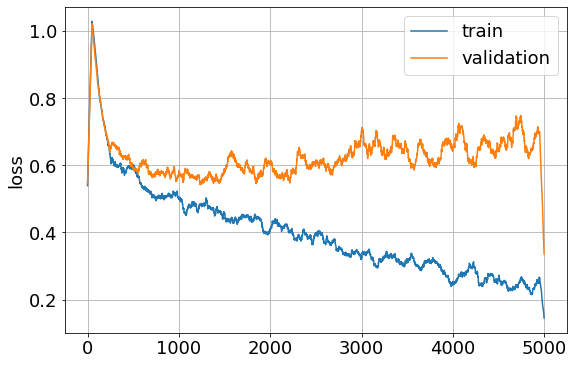

conv, num= 5


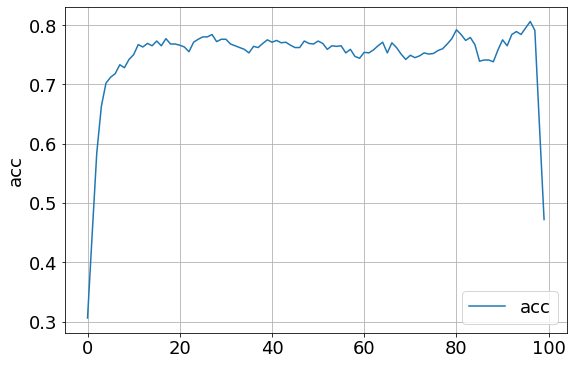

no conv


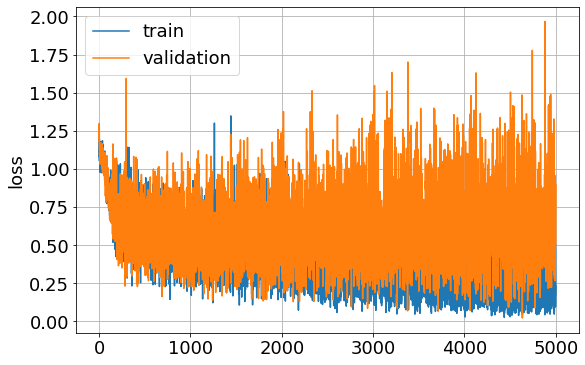

no conv


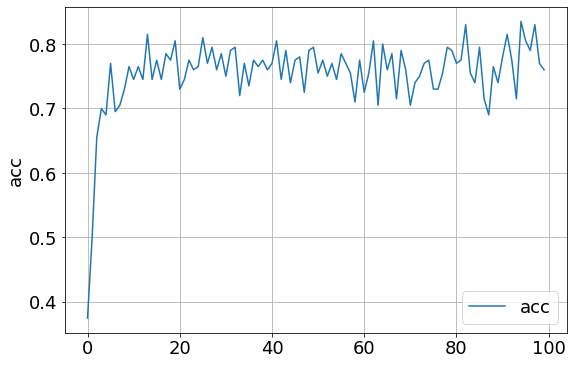

In [ ]:
model = Bert_Sentiment()
epochs = 5000
show_count = 50
batch_size = 20
max_length = 120
train_dataset = train_df
validation_dataset = validation_df
model_path = "/content/drive/MyDrive/rec/model_parameters/bert_sentiment.pth"
gpu=True
model = train(model, epochs, show_count, batch_size, max_length, train_dataset, validation_dataset, gpu, model_path)

In [ ]:
validation_loop(test_df, max_length, 200, model, gpu)

tensor(0.7850, device='cuda:0')

In [ ]:
model_path = "/content/drive/MyDrive/rec/model_parameters/bert_sentiment.pth"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
def get_f(n):
    tfpn = np.array(size=(4, ))
    
    if label == n:
        if 

In [ ]:
def get_f(test_df, max_length, model, gpu, n):
    with torch.no_grad():
        model.eval()
        tweet_tensor, attention_mask, label = get_input(test_df, len(test_df), max_length, gpu)
        tfpn = np.zeros((4, ))
        for i in range(len(test_df)):
            input = tweet_tensor[i].unsqueeze(0)
            att_mask = attention_mask[i].unsqueeze(0)
            label_i = label[i].unsqueeze(0)

            output = model(input, att_mask)
            if label_i == n:
                if output.argmax(-1) == label_i:
                    tfpn[0] += 1
                else:
                    tfpn[3] += 1
            else:
                if output.argmax(-1) == label_i:
                    tfpn[1] += 1
                else:
                    tfpn[2] += 1
            
            del output, input, att_mask, label_i
        recall = tfpn[0] / (tfpn[0] + tfpn[3])
        precision = tfpn[0] / (tfpn[0] + tfpn[2])
        f_value = 2*recall*precision / (recall + precision)
        return [recall, precision, f_value]

label_name = ["neutral", "positive", "negative"]
for i in range(3):
    print(label_name[i])
    f = get_f(test_df, 120, model, True, i)
    print("recall : ", f[0])
    print("precision : ", f[1])
    print("f_value : ", f[2])
    print("-------------------")

neutral
recall :  0.7741258741258741
precision :  0.7123552123552124
f_value :  0.7419571045576407
-------------------
positive
recall :  0.8251811594202898
precision :  0.6122311827956989
f_value :  0.7029320987654321
-------------------
negative
recall :  0.7462537462537463
precision :  0.5914489311163895
f_value :  0.6598939929328623
-------------------
